In [1]:
%matplotlib inline
import sys
BIN = '../../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms
import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

from fastai import data_block, basic_train, basic_data
import fastai

In [2]:
from my_nn_modules import AE_basic, AE_bn, AE_LeakyReLU, AE_bn_LeakyReLU

In [3]:
# Load data
#train = pd.read_pickle(BIN + 'processed_data/aod/partial_train.pkl')
#test = pd.read_pickle(BIN + 'processed_data/aod/partial_test.pkl')

#train = pd.read_pickle(BIN + 'processed_data/aod/full_train.pkl')
#test = pd.read_pickle(BIN + 'processed_data/aod/full_test.pkl')

train = pd.read_pickle(BIN + 'processed_data/aod/all_jets_partial_train.pkl')
test = pd.read_pickle(BIN + 'processed_data/aod/all_jets_partial_test.pkl')

#train = pd.read_pickle(BIN + 'processed_data/aod/all_jets_full_train.pkl')
#test = pd.read_pickle(BIN + 'processed_data/aod/all_jets_full_test.pkl')

#train['pt'] = train['pt'] / 1000.  # Convert to GeV
#test['pt'] = test['pt'] / 1000.  # Convert to GeV
#train['m'] = train['m'] / 1000.  # Convert to GeV
#test['m'] = test['m'] / 1000.  # Convert to GeV
#train['NegativeE'] = train['NegativeE'] / 1000.  # Convert to GeV
#test['NegativeE'] = test['NegativeE'] / 1000.  # Convert to GeV

#train['LeadingClusterPt'] = train['LeadingClusterPt'] / 1000.  # Convert to GeV
#test['LeadingClusterPt'] = test['LeadingClusterPt'] / 1000.  # Convert to GeV

#train['LeadingClusterSecondR'] = train['LeadingClusterSecondR'] / 1000.  # Convert to GeV
#test['LeadingClusterSecondR'] = test['LeadingClusterSecondR'] / 1000.  # Convert to GeV

#train['LeadingClusterSecondLambda'] = train['LeadingClusterSecondLambda'] / 1000.  # Convert to GeV
#test['LeadingClusterSecondLambda'] = test['LeadingClusterSecondLambda'] / 1000.  # Convert to GeV

train.pop('JetGhostArea')
test.pop('JetGhostArea')
train.pop('BchCorrCell')
test.pop('BchCorrCell')

# Remove all jets with EMFrac outside (-2, 2)
train = train[(train['EMFrac'] < 2) & (train['EMFrac'] > -2)]
test = test[(test['EMFrac'] < 2) & (test['EMFrac'] > -2)]

In [4]:
for key in test.keys():
    print(key)

pt
eta
phi
m
ActiveArea
ActiveArea4vec_eta
ActiveArea4vec_m
ActiveArea4vec_phi
ActiveArea4vec_pt
AverageLArQF
NegativeE
HECQuality
LArQuality
Width
WidthPhi
CentroidR
DetectorEta
LeadingClusterCenterLambda
LeadingClusterPt
LeadingClusterSecondLambda
LeadingClusterSecondR
N90Constituents
EMFrac
HECFrac
Timing
OotFracClusters10
OotFracClusters5


In [5]:
len(train.keys())

27

In [6]:
train.head()

,pt,eta,phi,m,ActiveArea,ActiveArea4vec_eta,ActiveArea4vec_m,ActiveArea4vec_phi,ActiveArea4vec_pt,AverageLArQF,...,LeadingClusterCenterLambda,LeadingClusterPt,LeadingClusterSecondLambda,LeadingClusterSecondR,N90Constituents,EMFrac,HECFrac,Timing,OotFracClusters10,OotFracClusters5
10841203,76395.562500,2.551444,-0.644569,8928.354492,0.528585,2.589474,0.151597,-0.652557,0.517514,1038.006104,...,1195.811523,39840.117188,44922.351562,8611.043945,4.0,0.302607,0.696391,0.244543,0.000000,0.000000
2478188,28675.375000,0.900313,-1.952856,7881.051758,0.508639,0.916086,0.147628,-1.951760,0.499531,122.948654,...,25.230358,7836.223145,28356.054688,7591.929688,12.0,0.766227,0.000000,1.181435,0.065003,0.221785
3171379,167436.843750,0.194945,-2.188446,13721.004883,0.518612,0.209248,0.150651,-2.178825,0.508215,56.737061,...,1502.329102,64280.050781,34982.253906,119096.179688,4.0,0.411470,0.000000,0.246874,0.015531,0.015531
10616755,34359.960938,1.563726,0.265730,5162.132812,0.478719,1.581886,0.134544,0.258161,0.470514,75.541565,...,1101.789062,19374.384766,538964.500000,33847.000000,5.0,0.443485,0.276325,-2.783324,0.112619,0.112619
3493566,22086.941406,1.128521,-1.433368,3426.685303,0.378986,1.075723,0.102861,-1.408685,0.371212,369.198914,...,2315.847412,3837.654541,59464.027344,4555.737793,4.0,0.543178,0.000000,-5.062422,0.315627,0.485570


In [11]:
def plot_data(data, e_range=None, pt_range=None, save=False, title=True, logy=False):

    plt.figure()
    plt.hist(data['pt'], bins=100, range=pt_range)
    plt.xlabel(r'$p_T$')
    if title:
        plt.suptitle('Train set')
    plt.ylabel('Number of jets')
    ms.sciy()
    if logy:
        plt.yscale('log')
    if save:
        plt.savefig('data_exploration_figures/hist_pt_train.png')
    
    plt.figure()
    plt.hist(data['eta'], bins=100)
    plt.xlabel(r'$\eta$')
    if title:
        plt.suptitle('Train set')
    plt.ylabel('Number of jets')
    ms.sciy()
    if save:
        plt.savefig('data_exploration_figures/hist_eta_train.png')
    
    plt.figure()
    plt.hist(data['phi'], bins=100)
    plt.xlabel(r'$\phi$')
    if title:
        plt.suptitle('Train set')
    plt.ylabel('Number of jets')
    ms.sciy()
    if save:
        plt.savefig('data_exploration_figures/hist_phi_train.png')    
        
    plt.figure()
    plt.hist(data['m'], bins=100, range=e_range)
    plt.xlabel(r'$m$')
    if title:
        plt.suptitle('Train set')
    plt.ylabel('Number of jets')
    ms.sciy()
    if logy:
        plt.yscale('log')
    if save:
        plt.savefig('data_exploration_figures/hist_m_train.png')

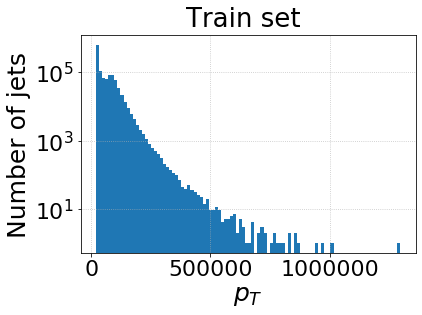

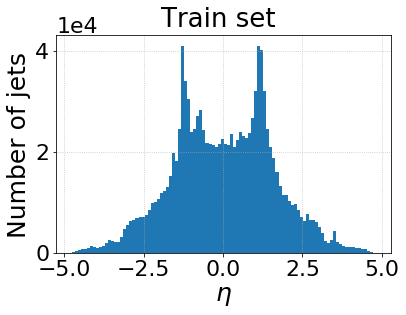

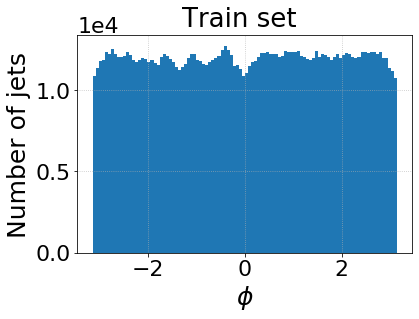

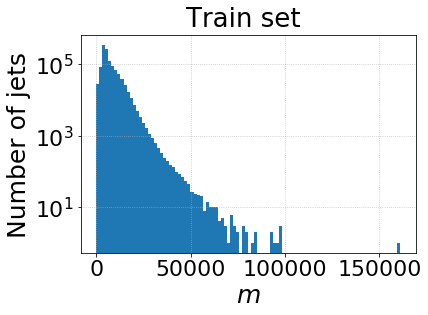

In [12]:
plot_data(test, logy=True)

In [7]:
test.keys()

Index(['pt', 'eta', 'phi', 'm', 'ActiveArea', 'ActiveArea4vec_eta',
       'ActiveArea4vec_m', 'ActiveArea4vec_phi', 'ActiveArea4vec_pt',
       'AverageLArQF', 'NegativeE', 'HECQuality', 'LArQuality', 'Width',
       'WidthPhi', 'CentroidR', 'DetectorEta', 'LeadingClusterCenterLambda',
       'LeadingClusterPt', 'LeadingClusterSecondLambda',
       'LeadingClusterSecondR', 'N90Constituents', 'EMFrac', 'HECFrac',
       'Timing', 'OotFracClusters10', 'OotFracClusters5'],
      dtype='object')

In [8]:
def plot_all(data, logy=False):
    for key in data.keys():
        plt.figure()
        plt.hist(data[key], bins=200)
        plt.xlabel(str(key))
        plt.ylabel('Number of jets')
        if logy:
            plt.yscale('log')
        else:
            ms.sciy()

/Users/ericwulff/miniconda3/envs/fastairoot/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


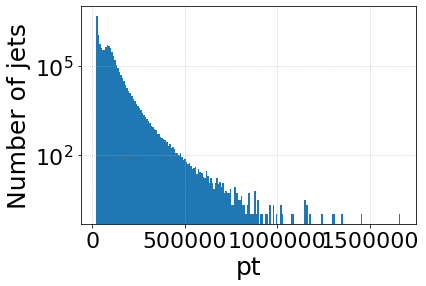

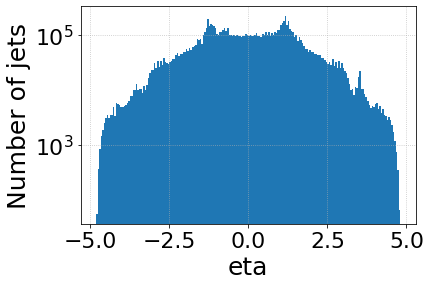

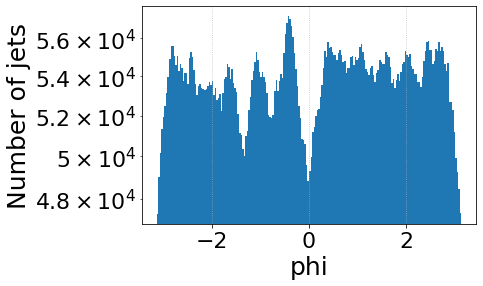

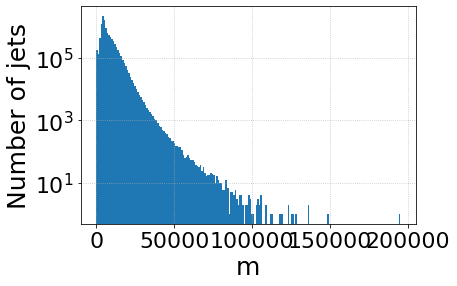

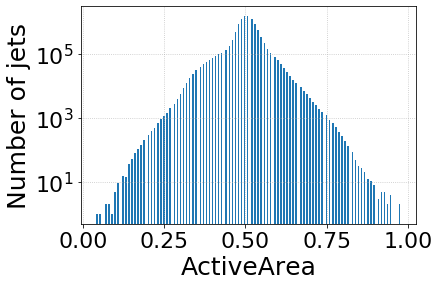

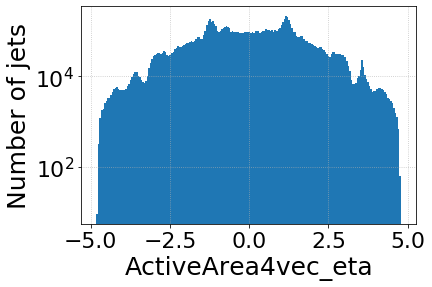

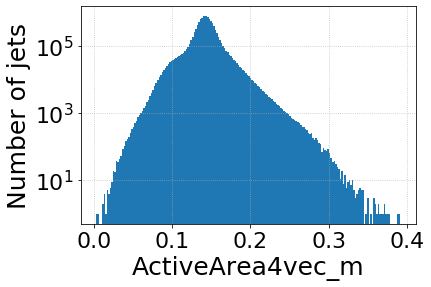

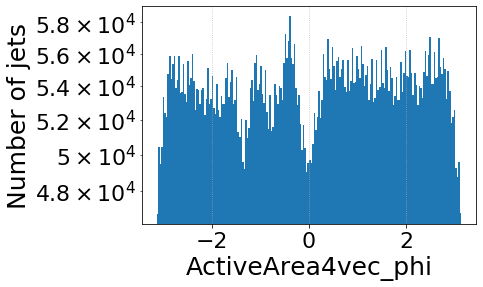

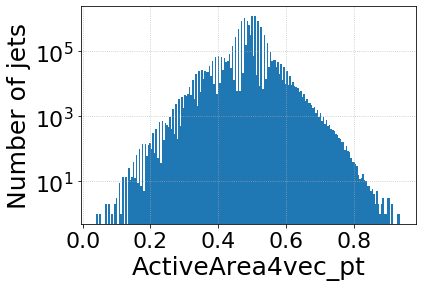

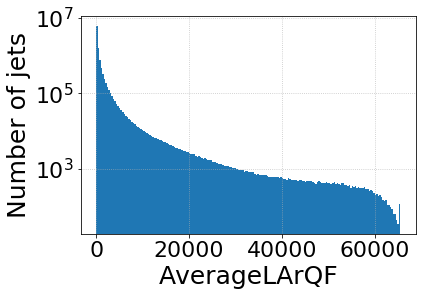

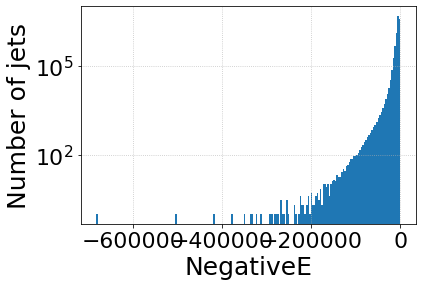

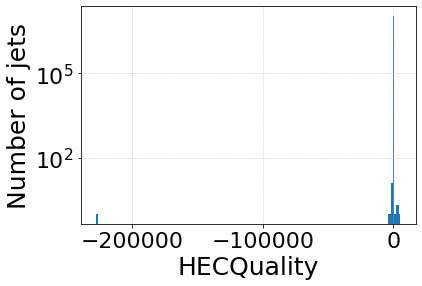

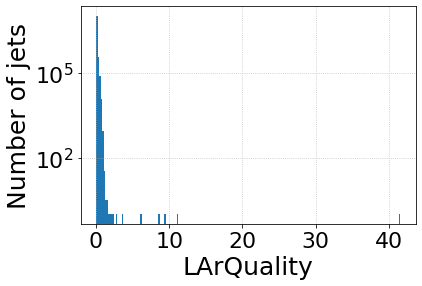

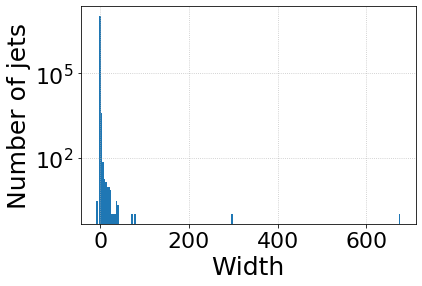

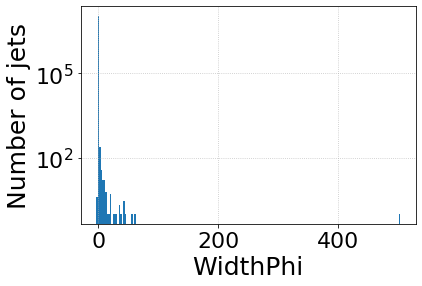

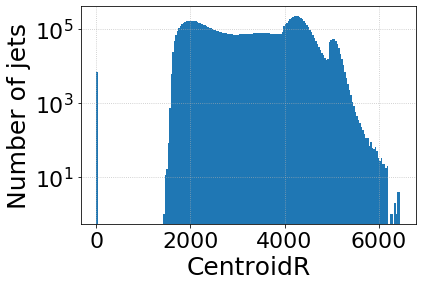

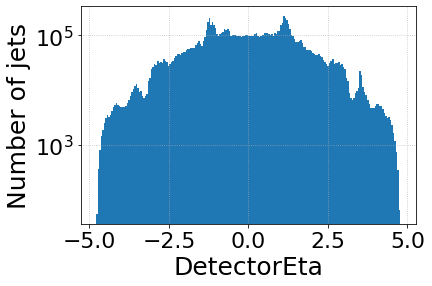

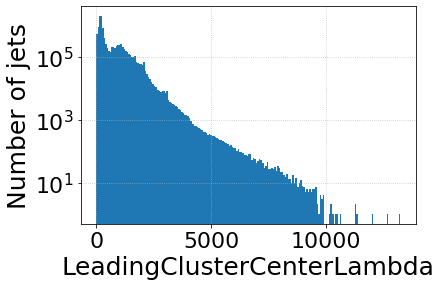

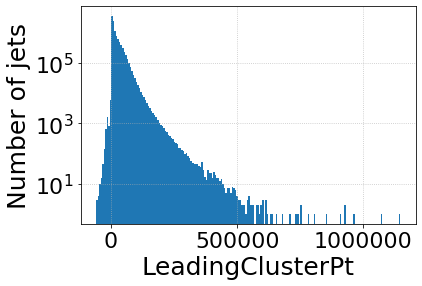

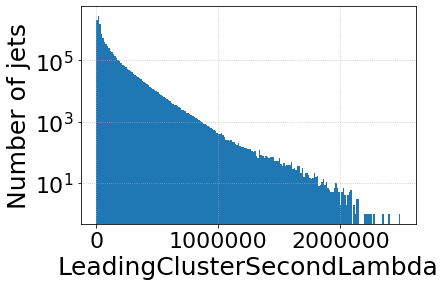

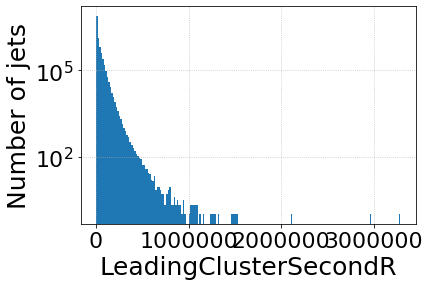

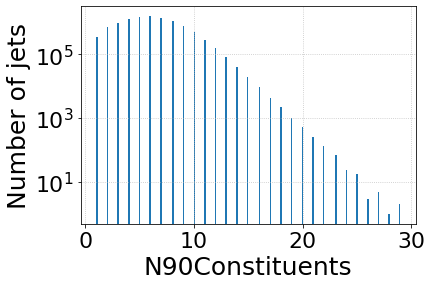

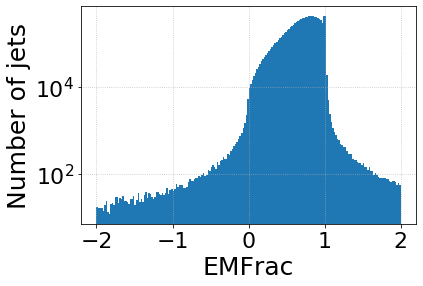

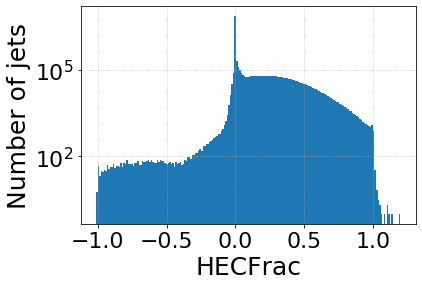

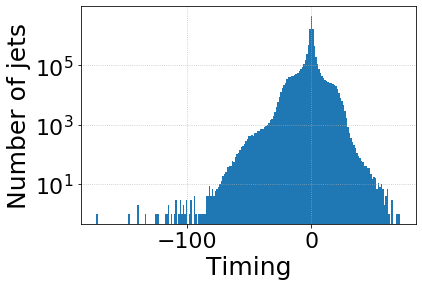

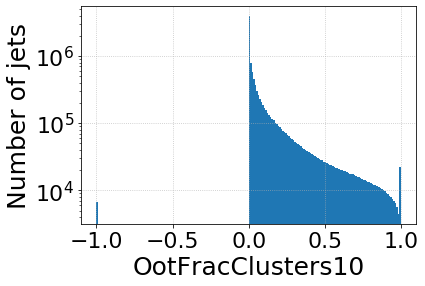

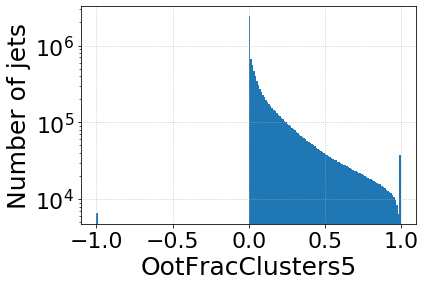

In [9]:
logy = True
plot_all(train, logy)

In [10]:
# Normalize
train_mean = train.mean()
train_std = train.std()

normed_train = (train - train_mean) / train_std
normed_test = (test - train_mean) / train_std

In [14]:
train_std

pt                              39.974013
eta                              1.569813
phi                              1.810123
m                                4.485599
ActiveArea                       0.045811
ActiveArea4vec_eta               1.581058
ActiveArea4vec_m                 0.018338
ActiveArea4vec_phi               1.810171
ActiveArea4vec_pt                0.044153
AverageLArQF                  3965.351961
NegativeE                     4164.117711
HECQuality                      69.552684
LArQuality                       0.078491
Width                            0.246745
WidthPhi                         0.175991
CentroidR                     1010.745945
DetectorEta                      1.559238
LeadingClusterCenterLambda     615.575818
LeadingClusterPt                21.754607
LeadingClusterSecondLambda     105.857137
LeadingClusterSecondR           28.476334
N90Constituents                  2.720535
EMFrac                           0.217687
HECFrac                          0

/Users/ericwulff/miniconda3/envs/fastairoot/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


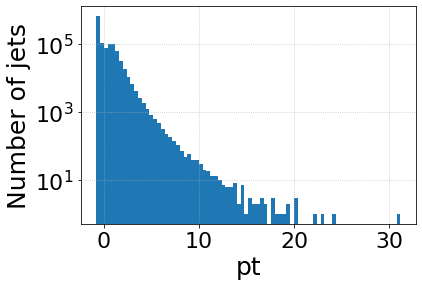

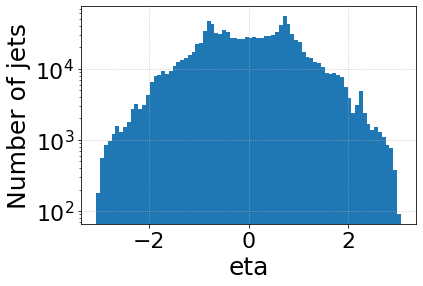

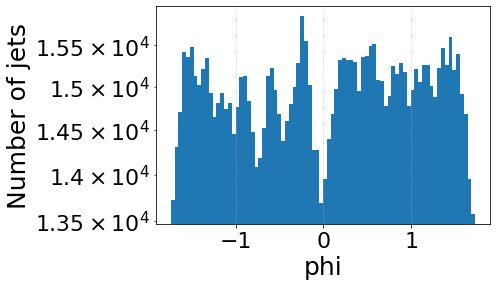

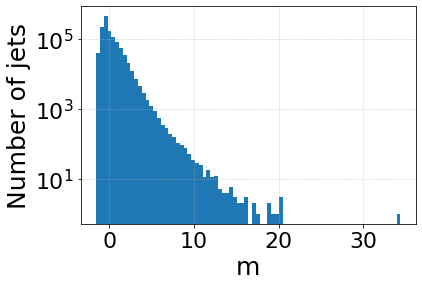

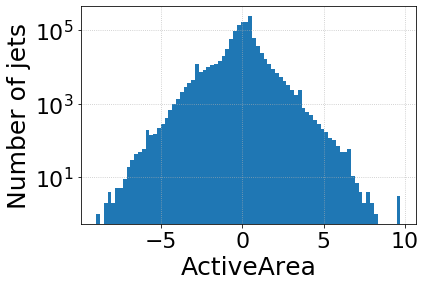

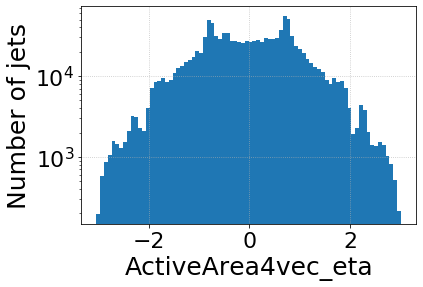

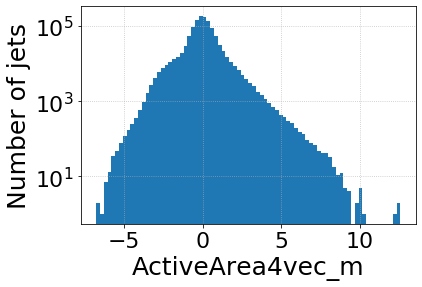

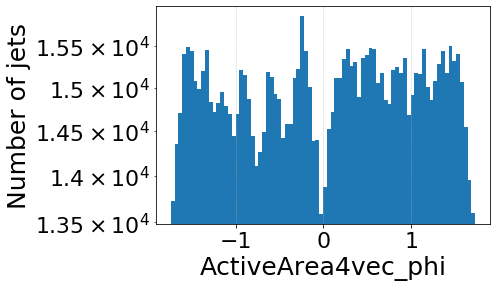

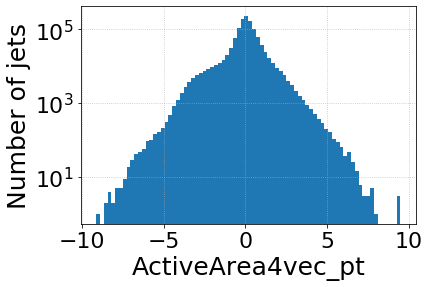

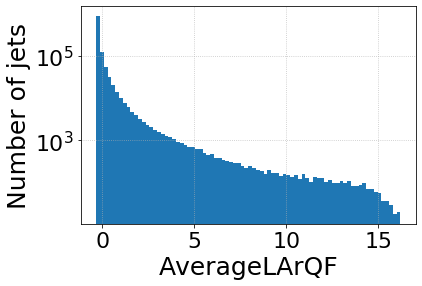

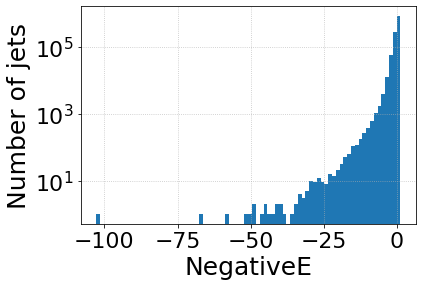

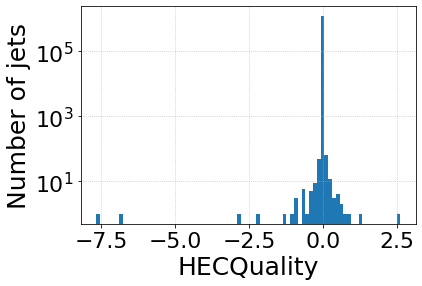

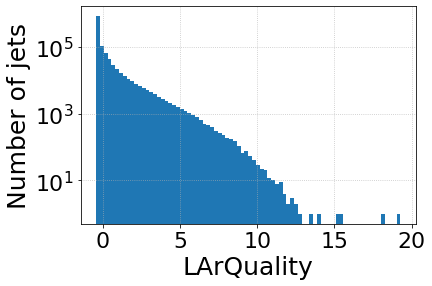

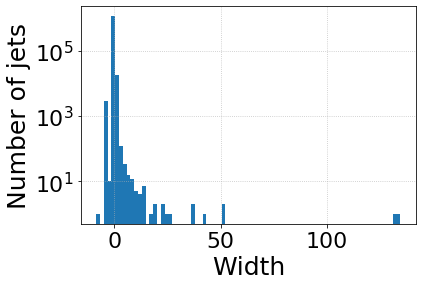

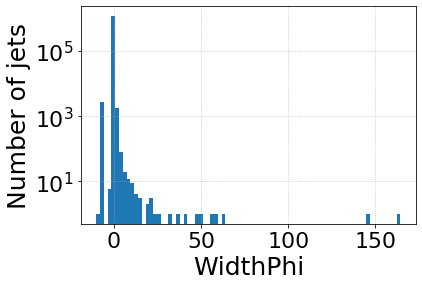

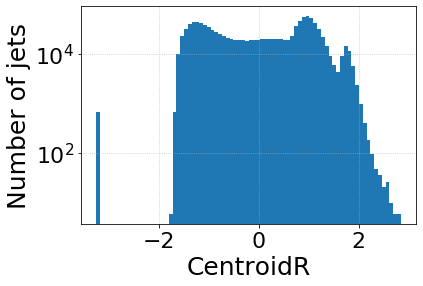

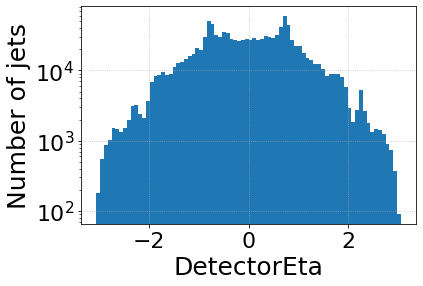

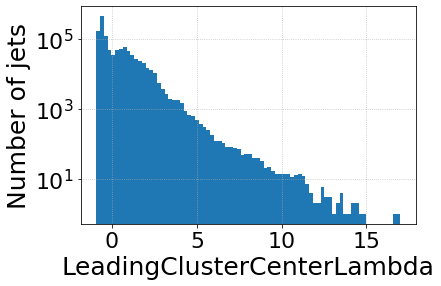

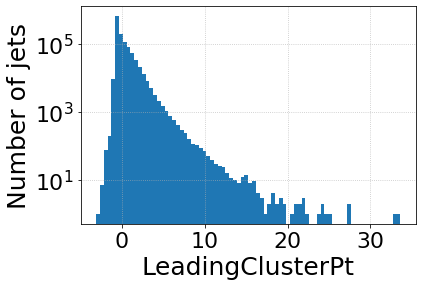

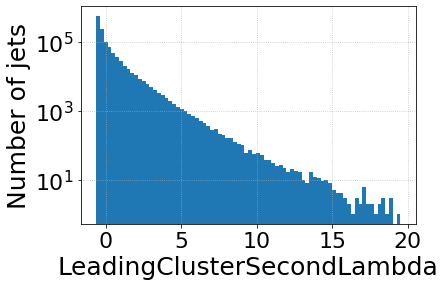

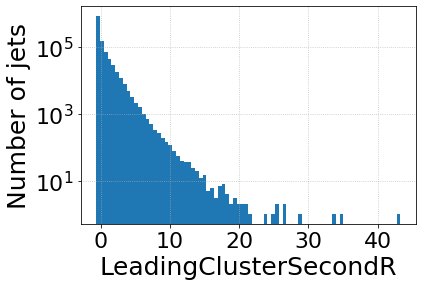

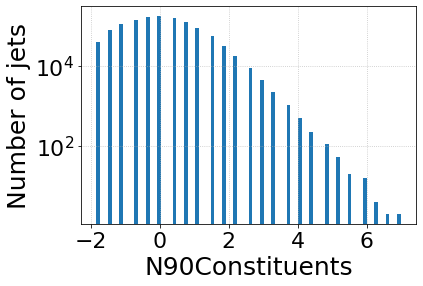

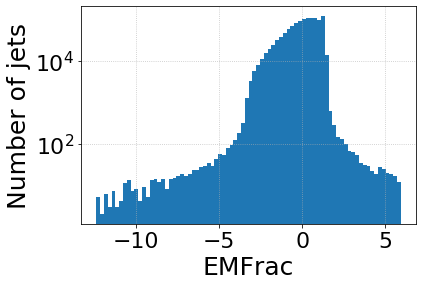

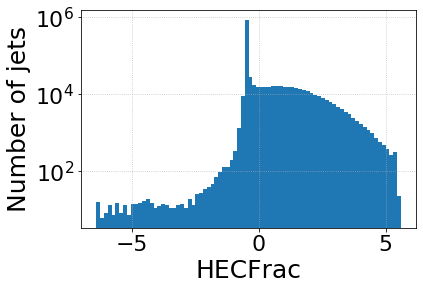

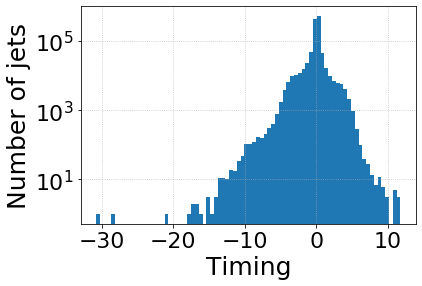

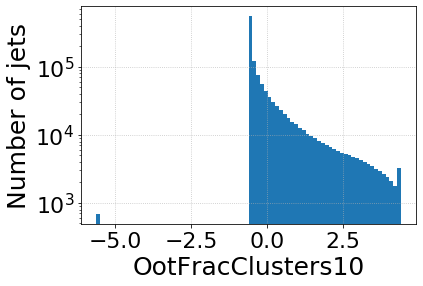

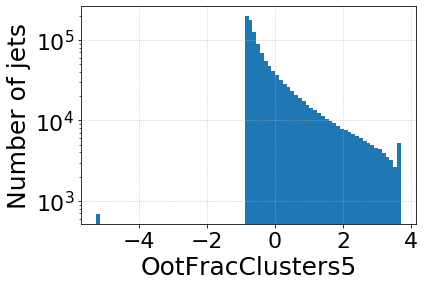

In [15]:
plot_all(data=normed_test, logy=True)

In [16]:
keys = ['pt',
        'eta',
        'phi',
        'm',
        'ActiveArea',
        'ActiveArea4vec_eta',
        'ActiveArea4vec_m',
        'ActiveArea4vec_phi',
        'ActiveArea4vec_pt',
        'AverageLArQF',
        'HECQuality',
        'LArQuality',
        'Width',
        'WidthPhi',
        'CentroidR',
        'DetectorEta',
        'LeadingClusterCenterLambda',
        'LeadingClusterPt',
        'LeadingClusterSecondLambda',
        'LeadingClusterSecondR',
        'N90Constituents',
        'EMFrac',
        'Timing',
        'OotFracClusters10',
        'HECQuality',
        'OotFracClusters5']
lognormed_variables = ['pt',
                       'LeadingClusterPt',
                       'LeadingClusterCenterLambda',
                       'LeadingClusterSecondLambda',
                       'LeadingClusterSecondR',
                       'CentroidR',
                       'LArQuality',                      
                      ]
custom_variables = [
                    'DetectorEta',
                    'ActiveArea4vec_eta',
                    'EMFrac',
                    'NegativeE',
                    ]
notnormed_variables = ['ActiveArea',
                       'ActiveArea4vec_m',
                       'ActiveArea4vec_pt',
                       'HECFrac',
                       'OotFracClusters10',
                       'OotFracClusters5',
                      ]

In [17]:
custom_normalized_test = test.copy()
for var in lognormed_variables:
    custom_normalized_test[var] = np.log10(test[var] + 100) - 2
custom_normalized_test['DetectorEta'] = test['DetectorEta'] / 5
custom_normalized_test['ActiveArea4vec_eta'] = test['ActiveArea4vec_eta'] / 5
custom_normalized_test['EMFrac'] = test['EMFrac'] / 5
custom_normalized_test['NegativeE'] = np.log10(-test['NegativeE'] + 1) / 4

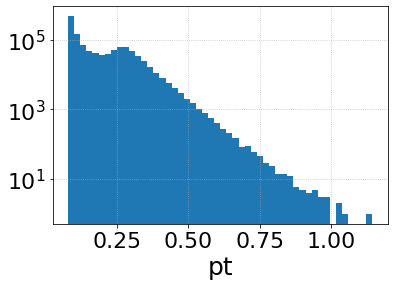

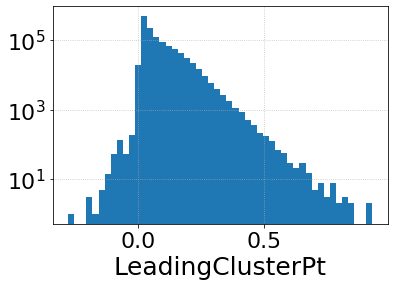

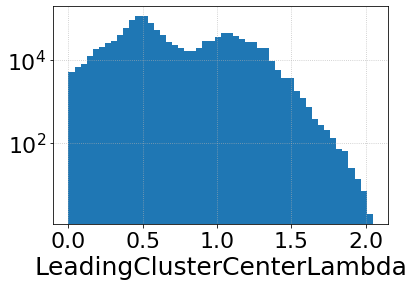

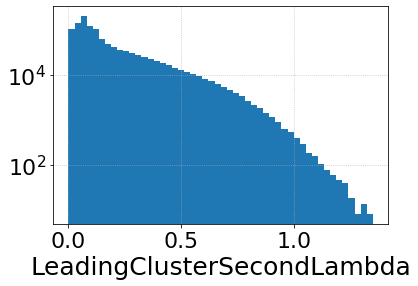

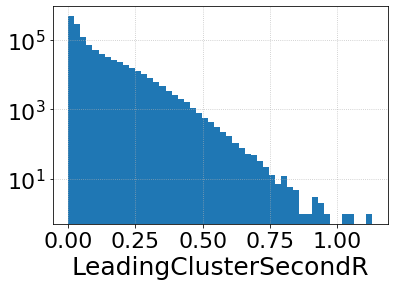

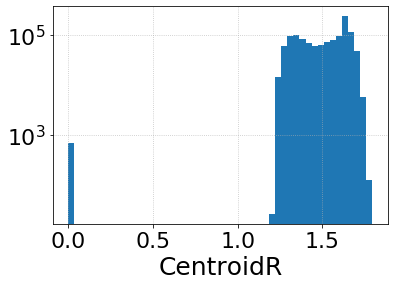

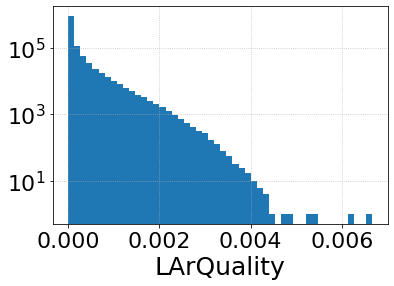

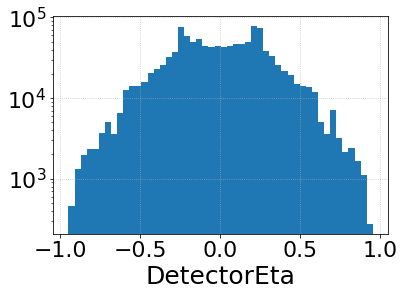

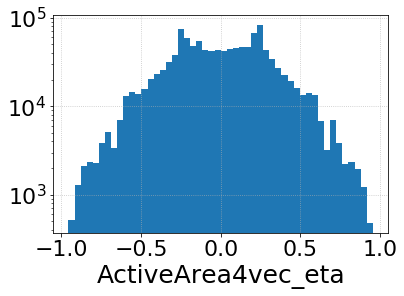

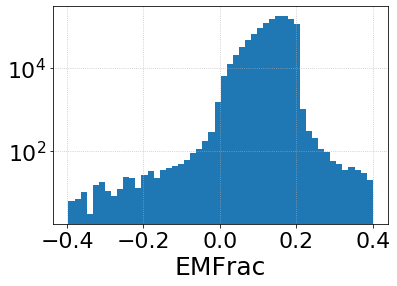

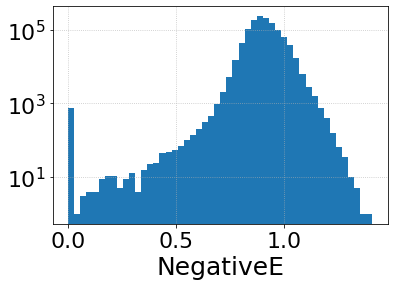

In [18]:
for var in lognormed_variables + custom_variables:
    plt.figure()
    plt.hist(custom_normalized_test[var], bins=50)
    plt.xlabel(var)
    plt.yscale('log')

In [25]:
from FunctionScaler import FunctionScaler
fs = FunctionScaler.FunctionScaler(FunctionScaler.TransformedFunction_Uniform(-1,1), downplay_outofbounds_lower_n_range=None, downplay_outofbounds_upper_n_range=None, downplay_outofbounds_lower_set_point=None, downplay_outofbounds_upper_set_point= None) # calling the normal function by name
#fs = FunctionScaler.FunctionScaler("gauss-11")
#fs = FunctionScaler.FunctionScaler("gauss")

In [34]:
scaling_data = test.values
fs.fit(scaling_data[:len(scaling_data)//5])

In [35]:
scaled_data = fs.transform(scaling_data)

In [36]:
scaled_df = pd.DataFrame(scaled_data, columns=test.columns)
scaled_df

,pt,eta,phi,m,ActiveArea,ActiveArea4vec_eta,ActiveArea4vec_m,ActiveArea4vec_phi,ActiveArea4vec_pt,AverageLArQF,...,LeadingClusterCenterLambda,LeadingClusterPt,LeadingClusterSecondLambda,LeadingClusterSecondR,N90Constituents,EMFrac,HECFrac,Timing,OotFracClusters10,OotFracClusters5
0,0.390043,-0.386469,0.500929,0.766332,0.517739,-0.389365,0.498250,0.501750,0.568862,-0.616126,...,-0.440313,-0.017421,0.257275,-0.262540,0.888051,0.867717,-0.946390,-0.544979,0.500511,0.349727
1,-0.951606,-0.524679,0.301509,-0.485258,0.285377,-0.532472,0.498292,0.300671,0.490708,0.399746,...,0.810650,-0.784699,0.994868,0.750896,0.183189,0.194122,-0.946390,-0.895761,0.840569,0.767764
2,0.105955,0.161984,-0.484120,0.471739,0.681749,0.150725,0.750603,-0.486891,0.774352,0.639248,...,-0.298394,-0.421117,0.064677,-0.327384,0.183189,0.429731,-0.946390,-0.681171,0.401437,0.153111
3,-0.534063,-0.296444,-0.033870,-0.358676,-0.962463,-0.336760,-0.972165,-0.020049,-0.956679,0.714807,...,-0.808381,-0.792191,0.124037,-0.320670,0.183189,0.609304,-0.946390,0.885648,0.963886,0.945762
4,0.866913,0.845441,-0.953916,0.884008,-0.508890,0.846605,-0.432226,-0.953991,-0.318293,0.663508,...,-0.592394,0.617290,-0.712145,-0.981659,0.447361,0.253248,0.636167,0.090879,-0.998761,-0.643266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194553,-0.745412,0.041642,-0.474969,-0.818928,0.002562,0.043947,0.116033,-0.478624,0.186683,0.986194,...,-0.614149,0.085854,-0.556029,-0.023208,-0.797716,0.466018,-0.946390,-0.977145,0.952444,0.947923
1194554,-0.912271,0.121598,0.782845,-0.891353,-0.508890,0.120776,-0.175343,0.783726,-0.442693,-0.935207,...,0.729656,0.066783,0.641303,0.765196,-0.616938,-0.848936,-0.946390,-0.538592,0.320579,0.052748
1194555,0.436765,-0.155184,0.340066,0.733217,0.285377,-0.153079,0.288205,0.343237,0.322177,-0.625885,...,0.629835,-0.061113,0.486511,0.857667,0.888051,0.234062,-0.946390,-0.207998,-0.303664,0.078754
1194556,-0.091901,0.467664,-0.496397,0.326493,0.888268,0.450559,0.914120,-0.481746,0.889639,0.002084,...,-0.084250,-0.612842,0.100411,-0.319997,-0.107027,-0.416922,-0.946390,-0.830583,0.664974,0.720675


/Users/ericwulff/miniconda3/envs/fastairoot/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


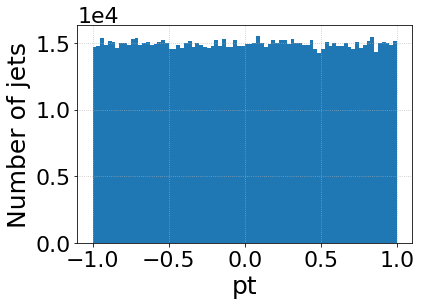

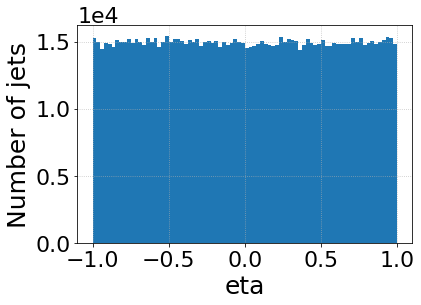

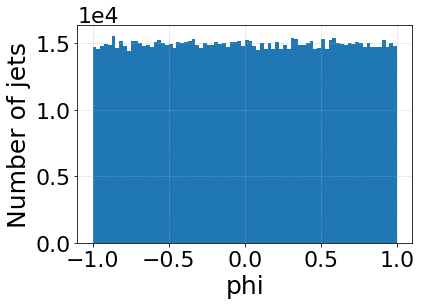

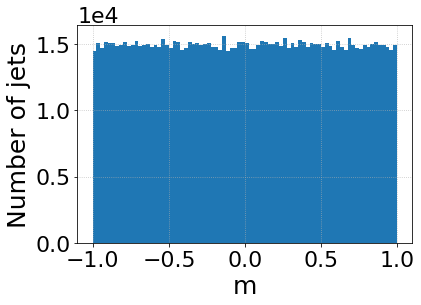

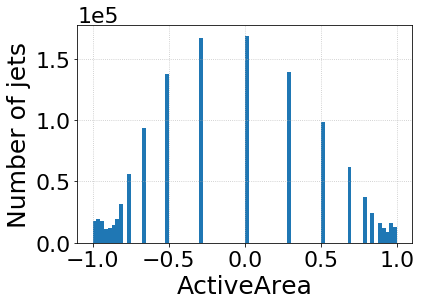

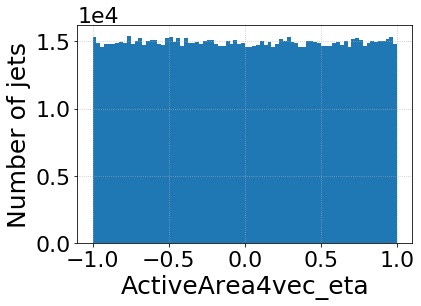

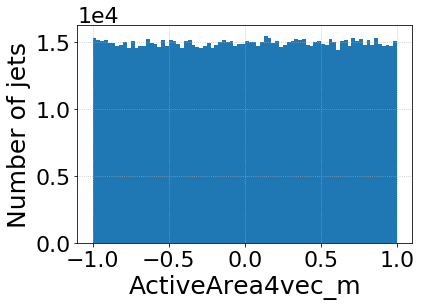

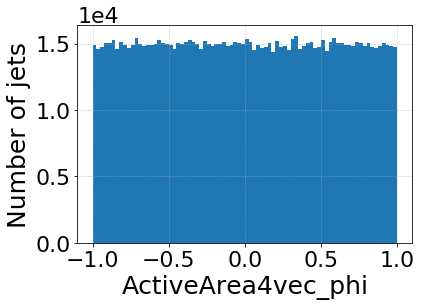

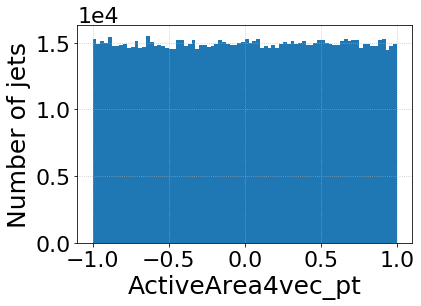

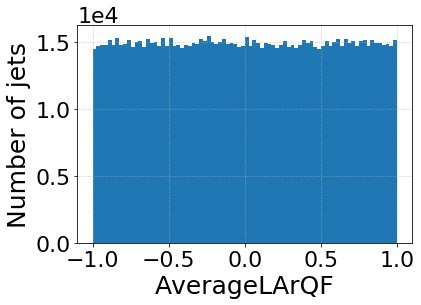

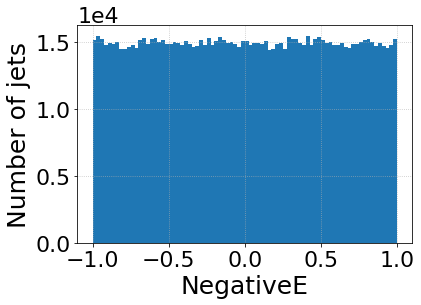

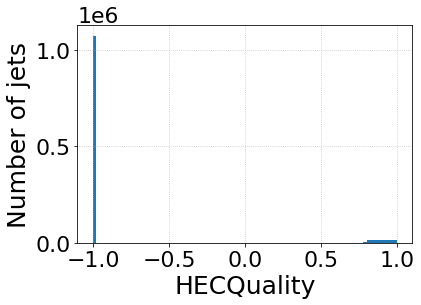

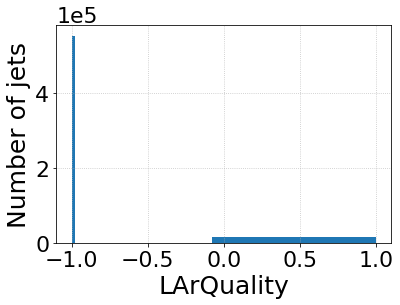

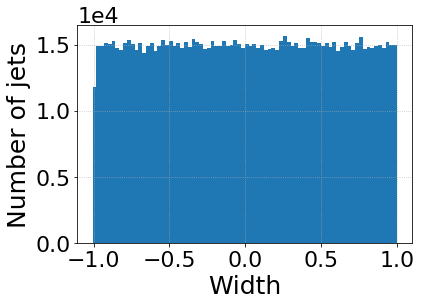

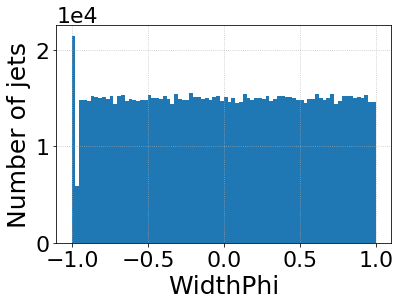

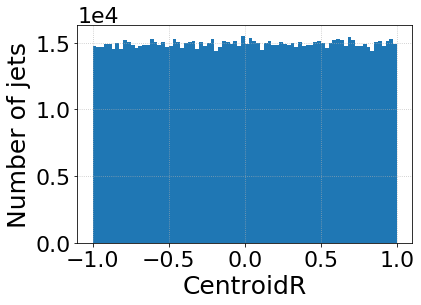

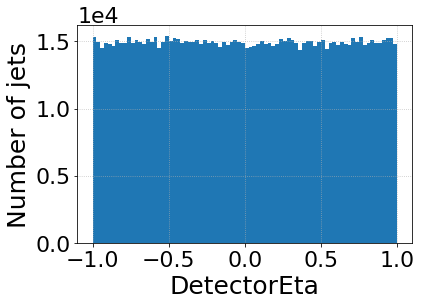

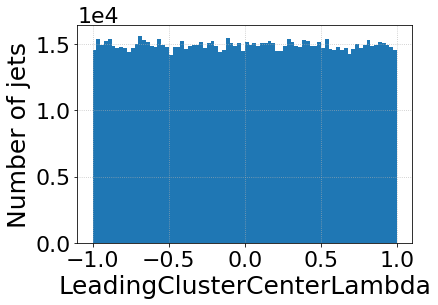

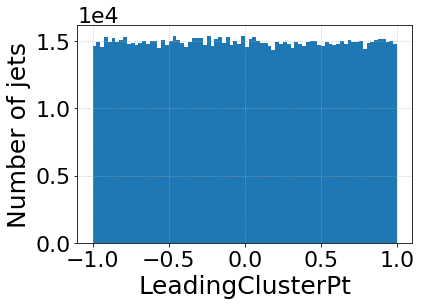

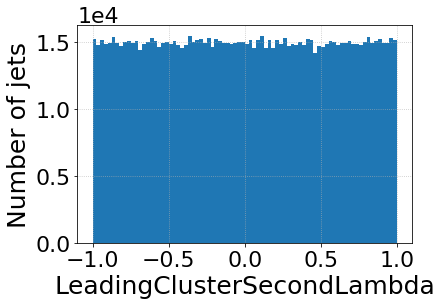

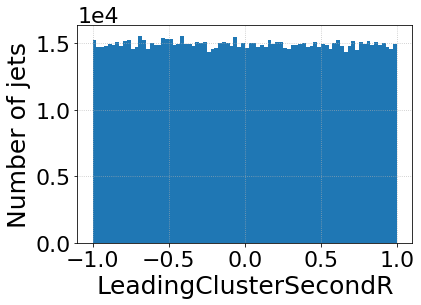

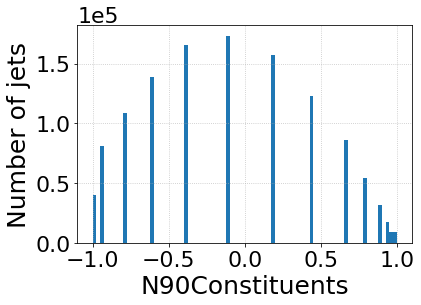

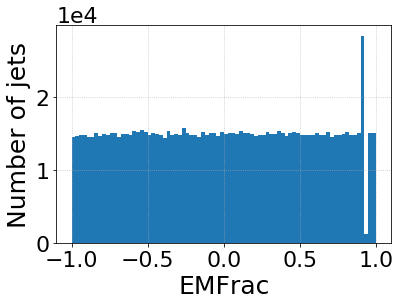

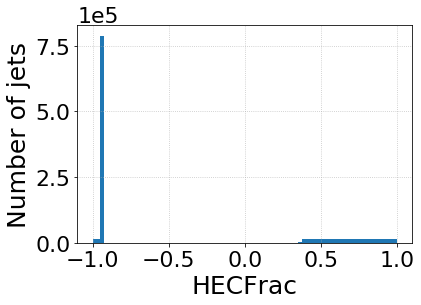

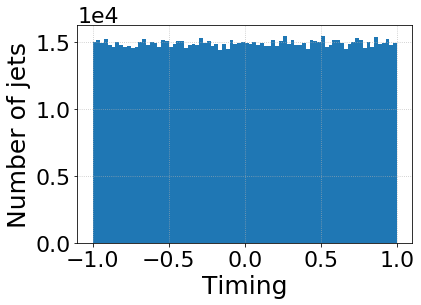

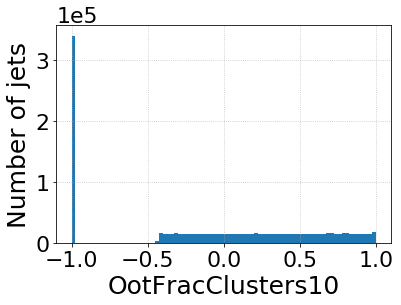

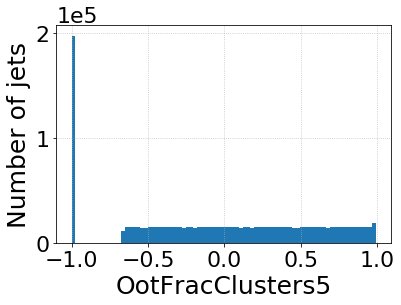

In [37]:
plot_all(scaled_df)

In [38]:
unscaled_data = fs.invtransform(scaled_data)
unscaled_df = pd.DataFrame(unscaled_data, columns=test.columns)
unscaled_df

,pt,eta,phi,m,ActiveArea,ActiveArea4vec_eta,ActiveArea4vec_m,ActiveArea4vec_phi,ActiveArea4vec_pt,AverageLArQF,...,LeadingClusterCenterLambda,LeadingClusterPt,LeadingClusterSecondLambda,LeadingClusterSecondR,N90Constituents,EMFrac,HECFrac,Timing,OotFracClusters10,OotFracClusters5
0,64.863484,-0.902595,1.579834,12.180009,0.528585,-0.919031,0.150354,1.583528,0.517317,91.368492,...,187.525040,10.927514,44.675496,5.070824,11.0,0.989743,0.00000,-0.749676,0.152594,0.178582
1,20.243803,-1.180367,0.960890,4.252781,0.518612,-1.197623,0.150355,0.958771,0.508866,661.976562,...,1482.144653,4.544718,733.357250,41.320734,7.0,0.795291,0.00000,-8.224196,0.465223,0.465223
2,35.982188,0.464039,-1.518692,8.380535,0.538559,0.440456,0.157737,-1.526209,0.528227,1380.255127,...,208.688309,6.720134,31.906838,4.629196,7.0,0.856882,0.00000,-1.487624,0.113851,0.113851
3,22.741240,-0.709135,-0.087447,4.540313,0.378986,-0.793019,0.093898,-0.038945,0.372828,1852.957275,...,107.426270,4.500013,34.787500,4.673611,7.0,0.906371,0.00000,4.316018,0.800357,0.800357
4,116.461711,2.202153,-2.989599,15.022626,0.488692,2.229548,0.135944,-2.989050,0.479833,1512.066040,...,163.887177,32.254002,9.952683,0.574806,8.0,0.810536,0.18875,0.338732,0.000000,0.003244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194553,21.367172,0.154227,-1.489258,3.153246,0.508639,0.164222,0.144090,-1.500091,0.498722,23808.675781,...,160.142410,12.692069,13.760451,7.080978,3.0,0.866719,0.00000,-19.574333,0.755235,0.806379
1194554,20.450113,0.357150,2.460836,2.628096,0.488692,0.361124,0.139965,2.463856,0.478841,17.804529,...,1267.566895,12.331765,110.803453,43.371973,4.0,0.352619,0.00000,-0.726758,0.089306,0.089306
1194555,70.351898,-0.364627,1.081663,11.621736,0.518612,-0.364045,0.146644,1.092119,0.507371,89.499710,...,1092.425781,10.285684,75.611047,61.365191,11.0,0.805578,0.00000,-0.033673,0.008208,0.095326
1194556,28.221410,1.133492,-1.557600,7.092904,0.568479,1.115149,0.173565,-1.509197,0.553214,272.373688,...,245.445679,5.546033,33.526902,4.677772,6.0,0.610915,0.00000,-4.303491,0.251015,0.411638


(array([5.983215e+06, 9.890310e+05, 7.144420e+05, 9.915900e+05, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00]),
 array([  20.000002,   36.452502,   52.905002,   69.357502, ..., 1615.8925  , 1632.345   , 1648.7975  , 1665.25    ]),
 <a list of 100 Patch objects>)

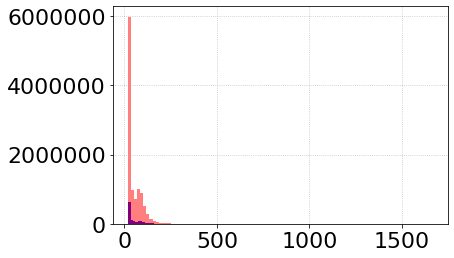

In [43]:
plt.figure()
plt.hist(unscaled_df['pt'], bins=100, color='b')
plt.hist(train['pt'], bins=100, color='r', alpha=0.5)

/Users/ericwulff/miniconda3/envs/fastairoot/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


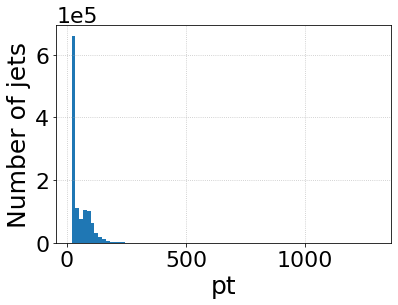

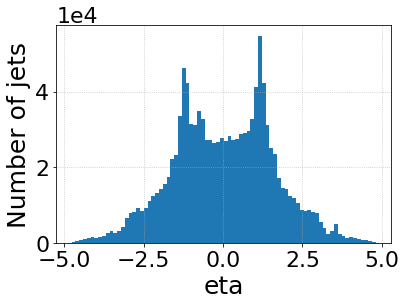

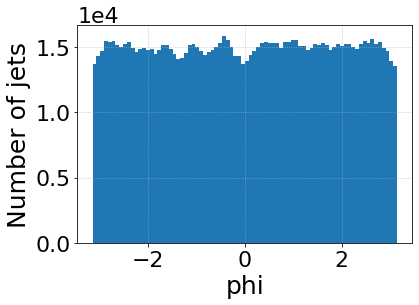

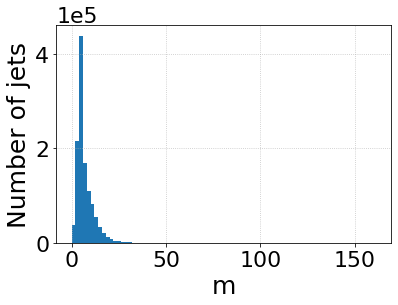

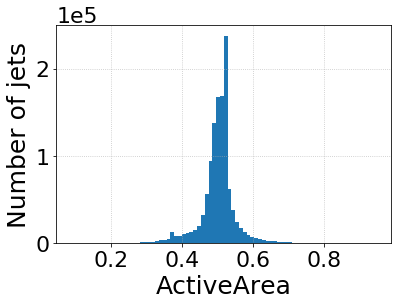

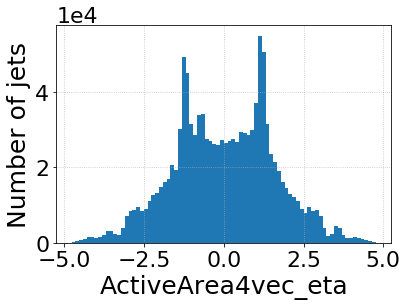

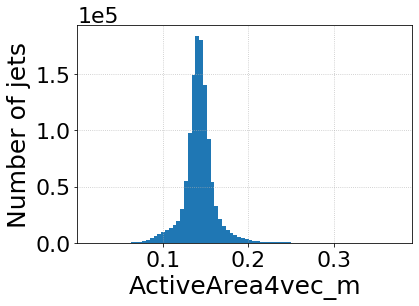

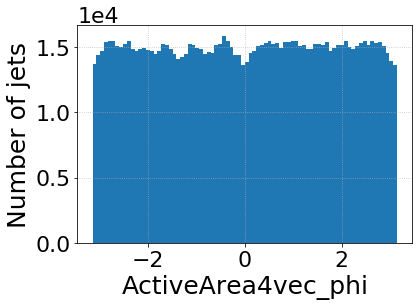

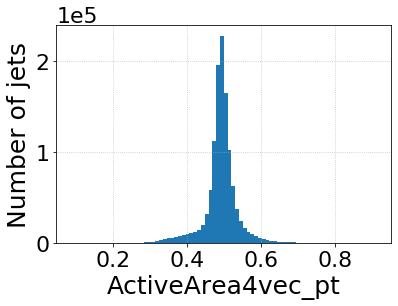

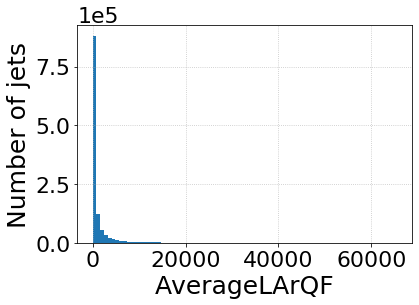

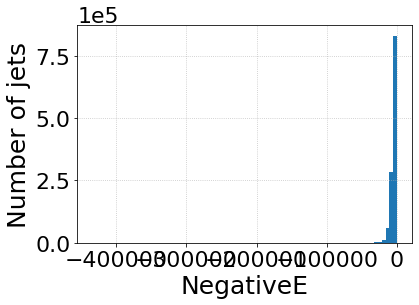

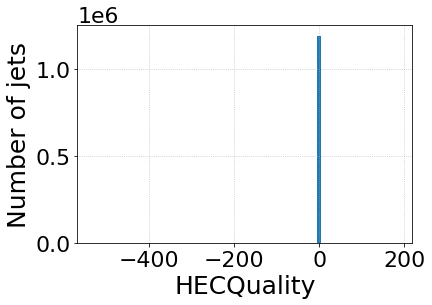

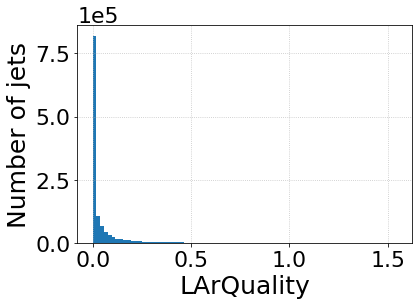

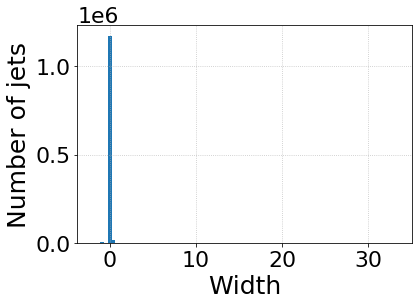

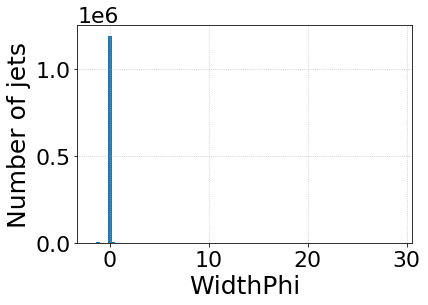

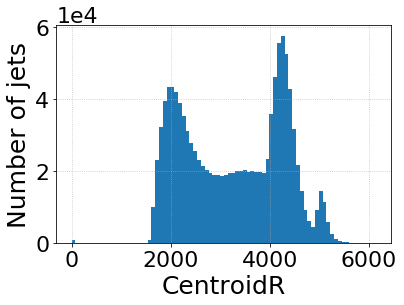

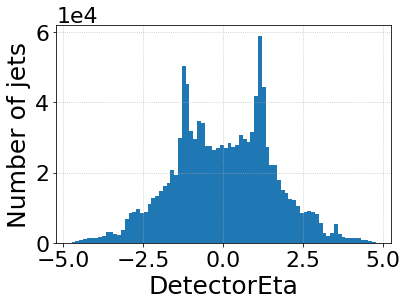

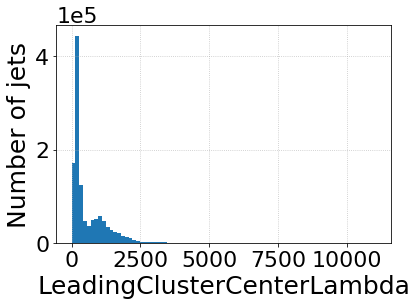

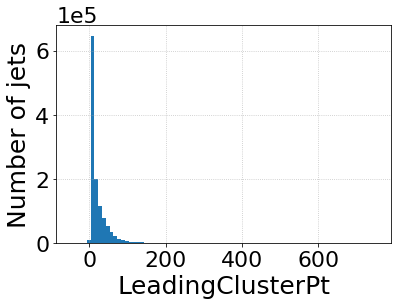

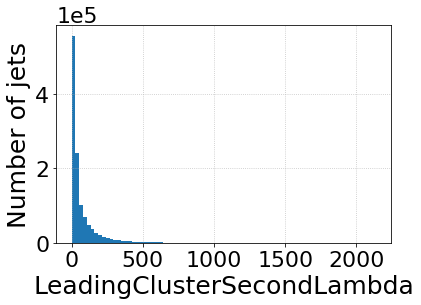

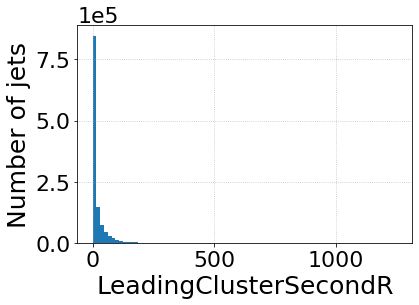

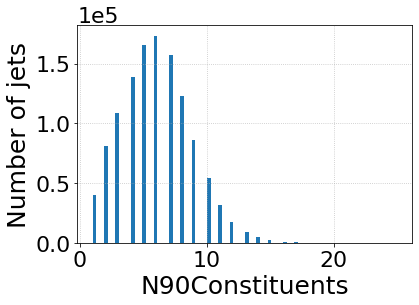

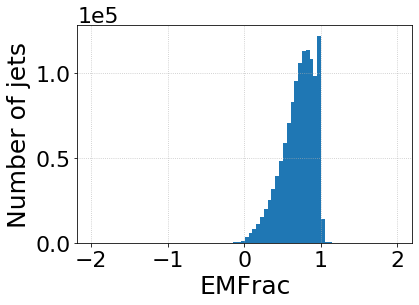

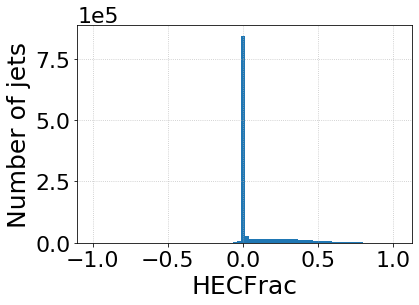

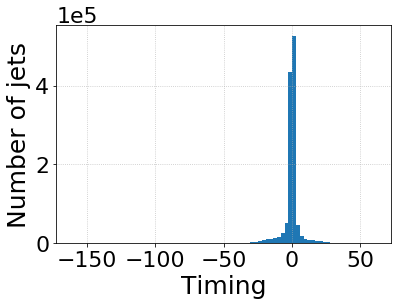

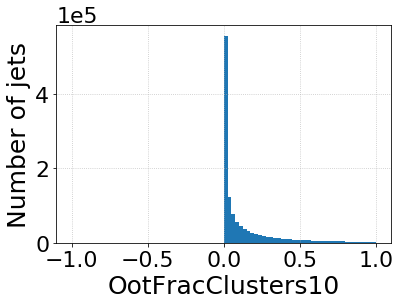

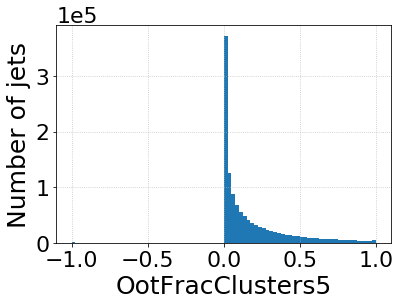

In [39]:
plot_all(unscaled_df)